In [1]:
import os, shutil
import io
from io import StringIO
import re
import sys
from contextlib import redirect_stdout
from keras import models
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import scipy.optimize as opt
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
from sklearn import metrics
import csv

import cnn_utilities as cn
import uq_utilities as uq

Using TensorFlow backend.


In [2]:
####### MTBD ###############

#### multitype bds model
# load trained model and normalization values
mtbd_mymodel = models.load_model("../saved_models/MTBD_128batch_20epoch.hdf5")
mtbd_mean_sd = pd.read_csv("../saved_models/train_mtbd_128batch_20epoch_normalization_label_mean_sd.csv", 
                     index_col = 0).to_numpy()

In [3]:
mtbd_train_means = mtbd_mean_sd[0,:]
mtbd_train_sd = mtbd_mean_sd[1,:]
mtbd_train_aux_priors_means = mtbd_train_means[7:,]
mtbd_train_aux_priors_sd = mtbd_train_sd[7:,]

num_locs = 5
max_tips = 502

In [4]:
mtbd_train_sd


array([4.31343737e-01, 4.29889023e-01, 4.30772031e-01, 4.30665600e-01,
       4.29890015e-01, 8.27639011e-01, 8.28084514e-01, 1.15415147e-02,
       2.32039573e-01, 1.66858828e+02, 4.08560692e+01, 5.60276902e+00])

In [5]:
train_mtbd_data = pd.read_csv("../data_files/training_mtbd.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()

train_mtbd_labels = pd.read_csv("../data_files/training_mtbd_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()



# log R0 sample rate and migration rate
train_mtbd_labels[:,5:12] = np.log(train_mtbd_labels[:,5:12])

# randomize data order
randomized_idx = np.random.permutation(train_mtbd_data.shape[0])
train_mtbd_data = train_mtbd_data[randomized_idx,:]
train_mtbd_labels = train_mtbd_labels[randomized_idx,:]

# setting up the data shape params and aux params
num_locs = 5
max_tips = 502
num_test = 1000 
num_validation = 5000 
num_sample = train_mtbd_data.shape[0]

num_tips = cn.get_num_tips(train_mtbd_data)
subsample_prop = train_mtbd_data[:,(max_tips-1) * 7]
mu = train_mtbd_data[:,(max_tips - 3) * 7]

In [6]:
print(train_mtbd_data.shape)
print(train_mtbd_labels.shape)

(193110, 3514)
(193110, 14)


In [7]:
# normalize labels
labels = train_mtbd_labels[0:num_sample,5:12]
norm_train_labels, train_label_means, train_label_sd = cn.normalize(labels[(num_test + num_validation):,:])
norm_validation_labels = cn.normalize(labels[num_test:num_test + num_validation,], (train_label_means, train_label_sd))
norm_test_labels = cn.normalize(labels[:num_test,], (train_label_means, train_label_sd))


# set up auxilliary priors and normalize; tree statistics and prior known parameter values (or ranges) 
# get num_tips and normalize
aux_priors_treestats = np.vstack((mu, subsample_prop, num_tips, 
                                  train_mtbd_labels[0:num_sample,12], 
                                  train_mtbd_labels[0:num_sample,13])).transpose()
norm_train_aux_priors_treestats, train_aux_priors_means, train_aux_priors_sd = cn.normalize(aux_priors_treestats[num_test + num_validation:,:])

norm_val_aux_priors_treestats = cn.normalize(aux_priors_treestats[num_test:num_test + num_validation,], 
                                            (train_aux_priors_means, train_aux_priors_sd))
norm_test_aux_priors_treestats = cn.normalize(aux_priors_treestats[:num_test,], 
                                            (train_aux_priors_means, train_aux_priors_sd))

norm_aux_priors_treestats = np.concatenate((norm_test_aux_priors_treestats, 
                                            norm_val_aux_priors_treestats, 
                                            norm_train_aux_priors_treestats))


# create data tensors
        
full_treeLocation_tensor, full_prior_tensor = cn.create_data_tensors(data = train_mtbd_data[0:num_sample,:], 
                                                                        mu = norm_aux_priors_treestats[:,0],
                                                                        subsample_prop = norm_aux_priors_treestats[:,1],
                                                                        num_tips = norm_aux_priors_treestats[:,2],
                                                                        tmrca = norm_aux_priors_treestats[:,3],
                                                                        mean_bl = norm_aux_priors_treestats[:,4],
                                                                        num_locs = num_locs,
                                                                        max_tips = max_tips,
                                                                        cblv_contains_mu_rho = True)

train_treeLocation_tensor, validation_treeLocation_tensor,  test_treeLocation_tensor = cn.create_train_val_test_tensors(full_treeLocation_tensor, 
                                                                                                                        num_validation, num_test)
train_prior_tensor, validation_prior_tensor,  test_prior_tensor = cn.create_train_val_test_tensors(full_prior_tensor, 
                                                                                                   num_validation, num_test)

print(train_treeLocation_tensor.shape, train_prior_tensor.shape)
print(test_treeLocation_tensor.shape, test_prior_tensor.shape)
print(validation_treeLocation_tensor.shape, validation_prior_tensor.shape)

(187110, 499, 7) (187110, 5, 2)
(1000, 499, 7) (1000, 5, 2)
(5000, 499, 7) (5000, 5, 2)


In [8]:
# make preds
# PREDICT R0_i, sample rate, migration rate
test_mtbd_normalized_preds = mtbd_mymodel.predict([train_treeLocation_tensor, train_prior_tensor])

In [9]:
# reversing normalization
test_cnn_mtbd_preds = cn.denormalize(test_mtbd_normalized_preds, mtbd_train_means[0:7], mtbd_train_sd[0:7])
test_log_preds = test_cnn_mtbd_preds

test_cnn_mtbd_preds = np.exp(test_cnn_mtbd_preds)
test_cnn_mtbd_labels = np.exp(labels[(num_validation + num_test):,:])

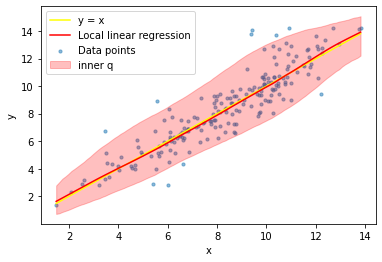

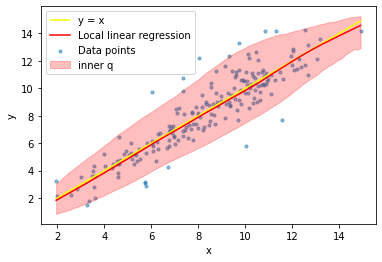

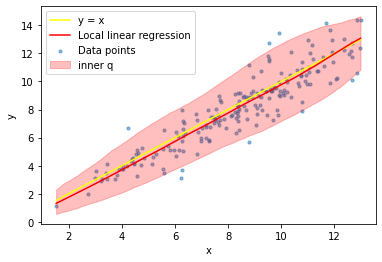

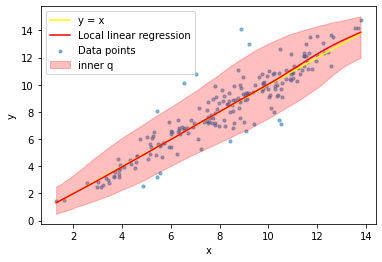

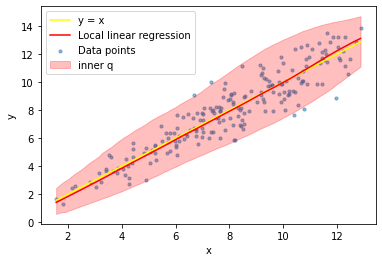

In [31]:
# compute lowess probability intervals
nn = test_cnn_mtbd_preds.shape[0]
for i in range(5):
    for qq in [.95]:
        f_mean, f_lower_q, f_upper_q = uq.fit_lowess_with_local_quantiles(test_cnn_mtbd_preds[0:nn,i], test_cnn_mtbd_labels[0:nn,i], frac=0.1, inner_quantile=qq)
        x = test_cnn_mtbd_preds[0:200,i]
        y = test_cnn_mtbd_labels[0:200,i]
        i_mean = f_mean(x)
        i_lower_q = f_lower_q(x)
        i_upper_q = f_upper_q(x)
        uq.plot_lowess_fit_quantile(x, y, f_mean, f_lower_q, f_upper_q)

In [10]:
mtbd_tree_preds = pd.read_table("../output/mtbd_nadeau2021_cnn_preds_full_and_a2.tsv",
                             header = 0, error_bad_lines = False).to_numpy()
fulltree_R0_preds = mtbd_tree_preds[0][0:5]
a2_R0_preds = mtbd_tree_preds[1][0:5]

In [14]:
nn = test_cnn_mtbd_preds.shape[0]

fulltree_q = []
a2_q = []
for k in range(5):
    m, lower_q, upper_q = uq.fit_lowess_with_local_quantiles(test_cnn_mtbd_preds[0:nn,k], test_cnn_mtbd_labels[0:nn,k], frac=0.1, inner_quantile=0.95)
    q = (lower_q(fulltree_R0_preds[k]), upper_q(fulltree_R0_preds[k]))    
    fulltree_q.append(q)    
    
    qa = (lower_q(a2_R0_preds[k]), upper_q(a2_R0_preds[k]))   
    a2_q.append(qa)

print(fulltree_q)
print(a2_q)

[(array(0.62621398), array(2.53383226)), (array(1.76098792), array(5.06405971)), (array(1.42023983), array(4.19132372)), (array(1.06982777), array(3.61768814)), (array(1.59445002), array(4.65564342))]
[(array(0.73417916), array(2.94229568)), (array(2.1165456), array(5.66587337)), (array(0.80391781), array(2.93883075)), (array(1.26038001), array(4.15967582)), (array(1.81718639), array(5.18444466))]


In [30]:
# write to file
fulltree_q_a2_q = np.hstack((np.array(fulltree_q).reshape((5,2)), np.array(a2_q).reshape((5,2))))
df_mtbd_ci = pd.DataFrame(fulltree_q_a2_q, index = ["R_" + str(i) for i in range(5)], 
                               columns = ["fulltree_lower_q", "fulltree_upper_q", "A2_lower_q", "A2_upper_q"])
df_mtbd_ci.to_csv('../output/mtbd_95ci.tsv', sep = "\t", index = True)